In [4]:
import pandas as pd

data = pd.read_excel("CAP_boiler_data_20secs.xlsx", engine="openpyxl")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263700 entries, 0 to 263699
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0           263700 non-null  datetime64[ns]
 1   Unnamed: 1           263700 non-null  datetime64[ns]
 2   COMBU.CALD5.FAIRE    263700 non-null  object        
 3   COMBU.CALD5.FMEZCLA  263700 non-null  object        
 4   COMBU.CALD5.FPET     263700 non-null  object        
 5   COMBU.CALD5.NAGUA    263700 non-null  object        
 6   COMBU.CALD5.O2       263700 non-null  object        
 7   COMBU.CALD5.P56      263700 non-null  object        
 8   COMBU.CALD5.PVAPOR   263700 non-null  object        
 9   COMBU.CALD5O2        263700 non-null  object        
dtypes: datetime64[ns](2), object(8)
memory usage: 20.1+ MB


# Limpieza de datos

In [5]:

data.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True, errors='ignore')
data = data.replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261833 entries, 0 to 263699
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   COMBU.CALD5.FAIRE    261833 non-null  float64
 1   COMBU.CALD5.FMEZCLA  261833 non-null  float64
 2   COMBU.CALD5.FPET     261833 non-null  float64
 3   COMBU.CALD5.NAGUA    261833 non-null  float64
 4   COMBU.CALD5.O2       261833 non-null  float64
 5   COMBU.CALD5.P56      261833 non-null  float64
 6   COMBU.CALD5.PVAPOR   261833 non-null  float64
 7   COMBU.CALD5O2        261833 non-null  float64
dtypes: float64(8)
memory usage: 18.0 MB


# Tipos de ataques inyectados

El dataset estando ya limpio posee 263.699 datos aproximadamente. Para las pruebas se inyectaran los ataques al 10% de los datos.

Se probará con dos tipos de ataques que afectarán a la variable de "salida" o de interés, COMBU.CALD5.O2, que corresponde a un sensor de oxígeno en la caldera de estudio, ataque de Denegación de Servicios (DoS) y ataque de Inyección de Datos Falsos (FDI). El ataque DoS se interpretará como que la señal que recibe el sensor será 0 por la interrupción del tráfico de la red. El ataque FDI multiplicará por una constante el resultado real de la señal.

Hay dos escenarios que se consideraran para ambos ataques, determinista o no determinista.

El determinista consiste en modificar los datos con un patron establecido, es decir, se hara un ataque cada x datos y esa cantidad no variará en el tiempo. Para llevarlo a cabo, se modificarán los datos de x en x, siendo x igual a (cantidad de datos a modificar) / (total de datos).

El no determinista modificará valores de manera totalmente aleatoria.

En primera instancia, se trabajarán ambos ataques por separado para saber si los modelos son capaces de clasificar los datos que están siendo atacados. Luego, se intentará identificar que tipo de ataque es el que está ocurriendo en los datos.

# Funciones para graficar

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def mostrar_resultados_grid_search(results):


    sorted_results = sorted(results, key=lambda x: x['avg_accuracy'], reverse=True)
    best_result = sorted_results[0]

    print("\nMejor combinación de hiperparámetros:")
    print(f"Accuracy: {best_result['avg_accuracy']:.4f} ± {best_result['std_accuracy']:.4f}")
    print(f"Parámetros: {best_result['params']}")
    print(f"Épocas promedio: {best_result['avg_epochs']:.1f}")

    # Visualizar curvas de aprendizaje para la mejor combinación
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for i, fold_result in enumerate(best_result['fold_results']):
        plt.plot(fold_result['train_losses'], label=f'Pliegue {i+1}')
    plt.title('Pérdida de Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i, fold_result in enumerate(best_result['fold_results']):
        plt.plot(fold_result['val_losses'], label=f'Pliegue {i+1}')
    plt.title('Pérdida de Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Matriz de confusión para la mejor combinación (promedio de los pliegues)
    all_y_true = np.concatenate([fold['y_true'] for fold in best_result['fold_results']])
    all_y_pred = np.concatenate([fold['y_pred'] for fold in best_result['fold_results']])
    cm = confusion_matrix(all_y_true, all_y_pred)

    print("\nMatriz de confusión (acumulada en los pliegues):")
    print(cm)

    # Gráfico de la matriz de confusión
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(all_y_true)))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')

    # Etiquetas en cada celda
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()


def mostrar_matriz_confusion(y_true, y_pred):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión')
    plt.tight_layout()
    plt.show()

    precision = conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[0,1]) if (conf_matrix[1,1] + conf_matrix[0,1]) > 0 else 0
    recall = conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[1,0]) if (conf_matrix[1,1] + conf_matrix[1,0]) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precisión: {precision:.4f}")
    print(f"Sensibilidad: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Multi Layer Perceptron

In [7]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.output(x)
        return x


# Función para entrenar MLP con Cross Validation

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


def train_evaluate_model(params, train_idx, test_idx):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Extraer parámetros
    num_epochs = params['num_epochs']
    pos_weight = params['pos_weight']
    lr = params['learning_rate']
    
    # Preparar datos
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]
    
    X_train_tensor = torch.FloatTensor(X_train_fold).to(device)
    X_test_tensor = torch.FloatTensor(X_test_fold).to(device)
    y_train_tensor = torch.FloatTensor(y_train_fold).view(-1, 1).to(device)
    y_test_tensor = torch.FloatTensor(y_test_fold).view(-1, 1).to(device)
    
    # Inicializar modelo
    input_size = X_train_fold.shape[1]
    model = MLP(input_size)
    model.to(device)
    
    # Configurar criterio y optimizador
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Parámetros para early stopping
    best_val_loss = float('inf')
    patience = 7
    counter = 0
    best_model_state = None
    
    # Entrenamiento
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Validación
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            val_loss = criterion(test_outputs, y_test_tensor)
            val_losses.append(val_loss.item())
            
            # Early stopping check
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model_state = model.state_dict()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping en la época {epoch+1}")
                    break
    
    # Cargar el mejor modelo
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # Evaluación final
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        predicted = (test_outputs >= 0.5).float()
        accuracy = (predicted == y_test_tensor).float().mean().item()
        
        y_pred = predicted.cpu().numpy().flatten()
        y_true = y_test_tensor.cpu().numpy().flatten()
        
    return {
        'accuracy': accuracy,
        'y_pred': y_pred,
        'y_true': y_true,
        'epochs_used': len(train_losses),
        'train_losses': train_losses,
        'val_losses': val_losses
    }

# DoS Determinista

# Entrenamiento básico

In [2]:
import torch
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import classification_report

def train_mlp(attacked_data, pos_weight=25, lr=0.002, num_epochs=100, patience=7, verbose=True):

    target = attacked_data['attack_label']
    X_train, X_test, y_train, y_test = train_test_split(attacked_data, target, test_size=0.2, random_state=42)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    X_train_tensor = torch.FloatTensor(X_train.drop('attack_label', axis=1).values).to(device)
    X_test_tensor = torch.FloatTensor(X_test.drop('attack_label', axis=1).values).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1).to(device)
    y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1).to(device)

    input_size = X_train.drop('attack_label', axis=1).shape[1]
    model = MLP(input_size)
    model.to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_loss = float('inf')
    counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            val_loss = criterion(test_outputs, y_test_tensor)
            predicted = (test_outputs >= 0.5).float()
            accuracy = (predicted == y_test_tensor).float().mean().item()

        if verbose:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                if verbose:
                    print(f"Early stopping en la época {epoch+1}")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        predicted = (test_outputs >= 0.5).float()
        y_pred = predicted.cpu().numpy().flatten()
        y_true = y_test_tensor.cpu().numpy().flatten()

    print("\nInforme de clasificación:")
    print(classification_report(y_true, y_pred))
    mostrar_matriz_confusion(y_true, y_pred)
    return


Epoch 1/100, Loss: 1.1831, Accuracy: 0.8976
Epoch 2/100, Loss: 1.1779, Accuracy: 0.8976
Epoch 3/100, Loss: 1.1741, Accuracy: 0.8976
Epoch 4/100, Loss: 1.1701, Accuracy: 0.8976
Epoch 5/100, Loss: 1.1673, Accuracy: 0.8976
Epoch 6/100, Loss: 1.1647, Accuracy: 0.8976
Epoch 7/100, Loss: 1.1619, Accuracy: 0.8976
Epoch 8/100, Loss: 1.1595, Accuracy: 0.8976
Epoch 9/100, Loss: 1.1566, Accuracy: 0.8976
Epoch 10/100, Loss: 1.1538, Accuracy: 0.8976
Epoch 11/100, Loss: 1.1513, Accuracy: 0.8976
Epoch 12/100, Loss: 1.1481, Accuracy: 0.8976
Epoch 13/100, Loss: 1.1442, Accuracy: 0.8976
Epoch 14/100, Loss: 1.1412, Accuracy: 0.8976
Epoch 15/100, Loss: 1.1369, Accuracy: 0.8976
Epoch 16/100, Loss: 1.1330, Accuracy: 0.8976
Epoch 17/100, Loss: 1.1276, Accuracy: 0.8976
Epoch 18/100, Loss: 1.1230, Accuracy: 0.8976
Epoch 19/100, Loss: 1.1175, Accuracy: 0.8976
Epoch 20/100, Loss: 1.1120, Accuracy: 0.8976
Epoch 21/100, Loss: 1.1057, Accuracy: 0.8976
Epoch 22/100, Loss: 1.0999, Accuracy: 0.8976
Epoch 23/100, Loss:

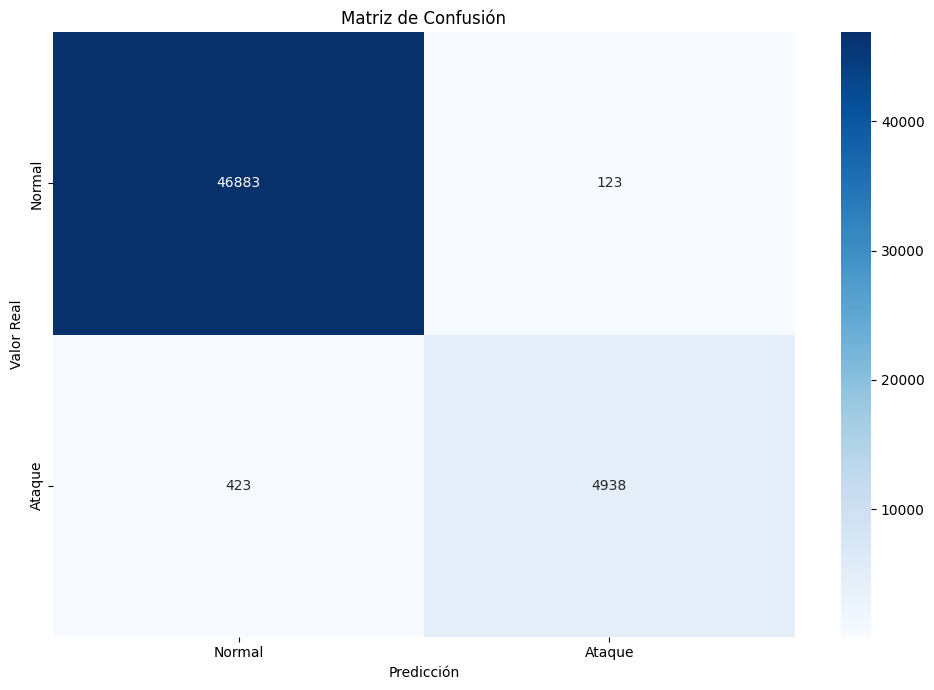

Precisión: 0.9757
Sensibilidad: 0.9211
F1 Score: 0.9476


In [15]:
from sklearn.preprocessing import StandardScaler
step = len(data) // 26000 # 10 por ciento de los datos atacados

attacked_data = data.copy()
scaler = StandardScaler()
attacked_data.iloc[:, :] = scaler.fit_transform(attacked_data)
attacked_data['attack_label'] = 0

# Aplicar ataques
for i in range(0, len(data), step):
    attacked_data.iloc[i, attacked_data.columns.get_loc('COMBU.CALD5.O2')] = 0
    attacked_data.iloc[i, attacked_data.columns.get_loc('attack_label')] = 1

train_mlp(attacked_data, pos_weight=8, lr=0.002, num_epochs=100, patience=7, verbose=True)

# Entrenamiento Completo

Falta ver si se le pueden meter batches y ordenarlo un poco


Combinación 1/6: {'num_epochs': 100, 'pos_weight': 5, 'learning_rate': 0.002}
  Training fold 1/5...
  Fold 1 - Accuracy: 0.9840, Epochs: 100
  Training fold 2/5...
  Fold 2 - Accuracy: 0.9565, Epochs: 100
  Training fold 3/5...
  Fold 3 - Accuracy: 0.9740, Epochs: 100
  Training fold 4/5...
  Fold 4 - Accuracy: 0.9794, Epochs: 100
  Training fold 5/5...
  Fold 5 - Accuracy: 0.9834, Epochs: 100
  Promedio: Accuracy 0.9754 ± 0.0101, Épocas 100.0

Combinación 2/6: {'num_epochs': 100, 'pos_weight': 8, 'learning_rate': 0.002}
  Training fold 1/5...
  Fold 1 - Accuracy: 0.9871, Epochs: 100
  Training fold 2/5...
  Fold 2 - Accuracy: 0.9848, Epochs: 100
  Training fold 3/5...
  Fold 3 - Accuracy: 0.9900, Epochs: 100
  Training fold 4/5...
  Fold 4 - Accuracy: 0.9911, Epochs: 100
  Training fold 5/5...
  Fold 5 - Accuracy: 0.9903, Epochs: 100
  Promedio: Accuracy 0.9886 ± 0.0024, Épocas 100.0

Combinación 3/6: {'num_epochs': 100, 'pos_weight': 10, 'learning_rate': 0.002}
  Training fold 1/5.

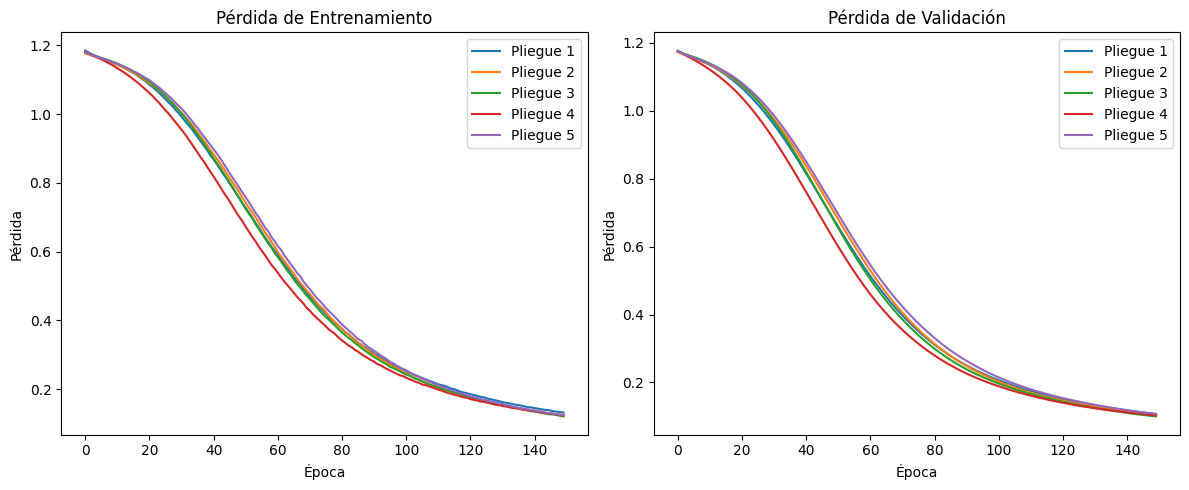


Matriz de confusión (acumulada en los pliegues):
[[235364    285]
 [   972  25212]]


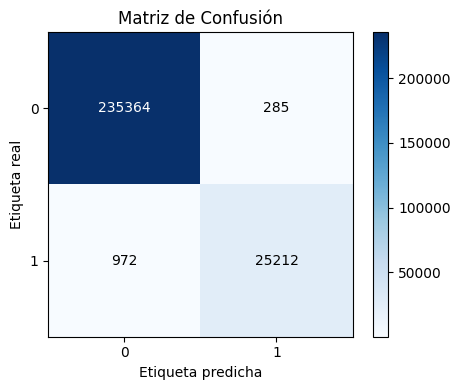

In [20]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import torch
from itertools import product

param_grid = {
    'num_epochs': [100, 150],
    'pos_weight': [5, 8, 10],
    'learning_rate': [0.002]
}

X = attacked_data.drop('attack_label', axis=1).values
y = attacked_data['attack_label'].values

n_folds = 5 
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

best_result = None
best_accuracy = 0
best_params = None

param_combinations = list(dict(zip(param_grid.keys(), values)) for values in product(*param_grid.values()))

for i, params in enumerate(param_combinations):
    fold_results = []
    
    print(f"\nCombinación {i+1}/{len(param_combinations)}: {params}")
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"  Training fold {fold+1}/{n_folds}...")
        
        result = train_evaluate_model(params, train_idx, test_idx)
        fold_results.append(result)
        
        print(f"  Fold {fold+1} - Accuracy: {result['accuracy']:.4f}, Epochs: {result['epochs_used']}")
    
    avg_accuracy = np.mean([r['accuracy'] for r in fold_results])
    std_accuracy = np.std([r['accuracy'] for r in fold_results])
    avg_epochs = np.mean([r['epochs_used'] for r in fold_results])
    
    print(f"  Promedio: Accuracy {avg_accuracy:.4f} ± {std_accuracy:.4f}, Épocas {avg_epochs:.1f}")
    
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_params = params
        best_result = {
            'params': params,
            'avg_accuracy': avg_accuracy,
            'std_accuracy': std_accuracy,
            'avg_epochs': avg_epochs,
            'fold_results': fold_results
        }

print(f"Mejor combinación: {best_params}")
print(f"Mejor accuracy promedio: {best_accuracy:.4f}")

mostrar_resultados_grid_search([best_result])


# FDI Determinista

Epoch 1/100, Loss: 1.3153, Accuracy: 0.8974
Epoch 2/100, Loss: 1.3123, Accuracy: 0.8972
Epoch 3/100, Loss: 1.3098, Accuracy: 0.8972
Epoch 4/100, Loss: 1.3088, Accuracy: 0.8972
Epoch 5/100, Loss: 1.3069, Accuracy: 0.8972
Epoch 6/100, Loss: 1.3060, Accuracy: 0.8972
Epoch 7/100, Loss: 1.3048, Accuracy: 0.8972
Epoch 8/100, Loss: 1.3035, Accuracy: 0.8972
Epoch 9/100, Loss: 1.3016, Accuracy: 0.8972
Epoch 10/100, Loss: 1.2995, Accuracy: 0.8972
Epoch 11/100, Loss: 1.2981, Accuracy: 0.8972
Epoch 12/100, Loss: 1.2975, Accuracy: 0.8972
Epoch 13/100, Loss: 1.2952, Accuracy: 0.8973
Epoch 14/100, Loss: 1.2933, Accuracy: 0.8976
Epoch 15/100, Loss: 1.2917, Accuracy: 0.8980
Epoch 16/100, Loss: 1.2899, Accuracy: 0.8982
Epoch 17/100, Loss: 1.2870, Accuracy: 0.8981
Epoch 18/100, Loss: 1.2857, Accuracy: 0.8973
Epoch 19/100, Loss: 1.2842, Accuracy: 0.8974
Epoch 20/100, Loss: 1.2815, Accuracy: 0.8971
Epoch 21/100, Loss: 1.2790, Accuracy: 0.8976
Epoch 22/100, Loss: 1.2774, Accuracy: 0.8975
Epoch 23/100, Loss:

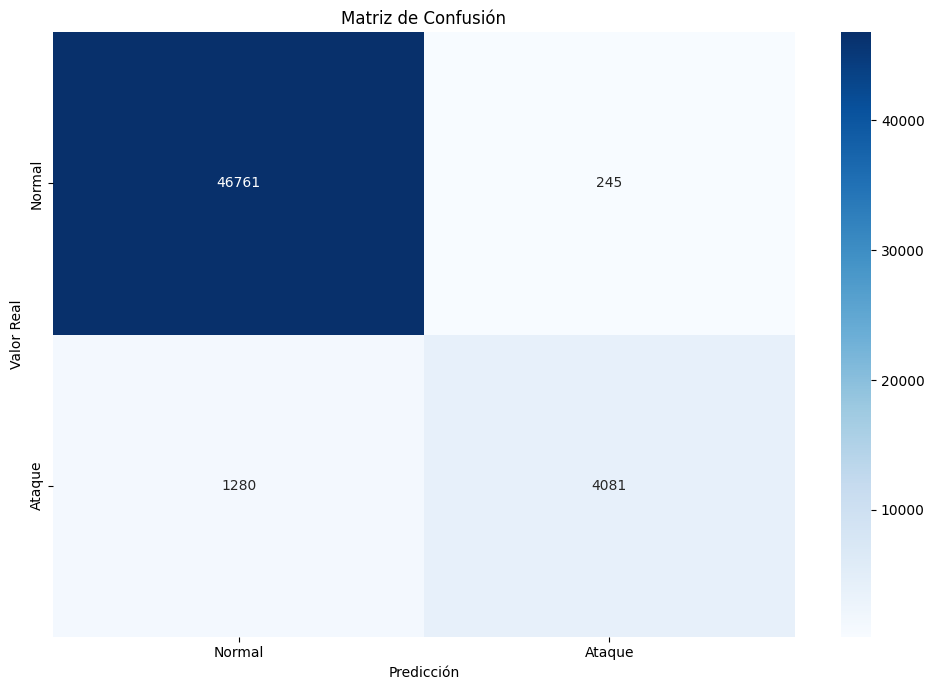

Precisión: 0.9434
Sensibilidad: 0.7612
F1 Score: 0.8426


In [28]:
step = len(data) // 26000 # 10 por ciento de los datos atacados

attacked_data = data.copy()
scaler = StandardScaler()
attacked_data.iloc[:, :] = scaler.fit_transform(attacked_data)
attacked_data['attack_label'] = 0

# Aplicar ataques
for i in range(0, len(data), step):
    attacked_data.iloc[i, attacked_data.columns.get_loc('COMBU.CALD5.O2')] *= 1.5
    attacked_data.iloc[i, attacked_data.columns.get_loc('attack_label')] = 1

train_mlp(attacked_data, pos_weight=10, lr=0.002, num_epochs=100, patience=7, verbose=True)

A medida que aumentamos la cantidad de datos atacados, hay que ir bajando un poco el peso extra de los labels de ataque.

# RNN1D

Esta red será útil ya que los datos de la caldera son series temporales.

In [29]:
import torch.nn as nn

class RNN1D(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(RNN1D, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Capa LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Capas fully connected
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        
        # Inicializar estados ocultos
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Tomar solo el último output
        last_output = lstm_out[:, -1, :]
        
        # Pasar por las capas fully connected
        x = self.fc1(last_output)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

 preparar los datos en formato de secuencias

In [30]:
def prepare_sequences(data, sequence_length=10):
    """
    Prepara los datos en secuencias para la RNN
    """
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Tomar secuencia de datos
        seq = data.iloc[i:i + sequence_length].drop('attack_label', axis=1).values
        # La etiqueta será la del último elemento de la secuencia
        label = data.iloc[i + sequence_length]['attack_label']
        
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# Entrenamos la RNN

Epoch 1/20, Train Loss: 0.2355, Val Loss: 0.0216, Accuracy: 0.9909
Epoch 2/20, Train Loss: 0.0191, Val Loss: 0.0115, Accuracy: 0.9960
Epoch 3/20, Train Loss: 0.0126, Val Loss: 0.0087, Accuracy: 0.9968
Epoch 4/20, Train Loss: 0.0089, Val Loss: 0.0057, Accuracy: 0.9979
Epoch 5/20, Train Loss: 0.0079, Val Loss: 0.0078, Accuracy: 0.9974
Epoch 6/20, Train Loss: 0.0079, Val Loss: 0.0057, Accuracy: 0.9977
Epoch 7/20, Train Loss: 0.0062, Val Loss: 0.0034, Accuracy: 0.9986
Epoch 8/20, Train Loss: 0.0055, Val Loss: 0.0042, Accuracy: 0.9985
Epoch 9/20, Train Loss: 0.0050, Val Loss: 0.0032, Accuracy: 0.9988
Epoch 10/20, Train Loss: 0.0049, Val Loss: 0.0023, Accuracy: 0.9991
Epoch 11/20, Train Loss: 0.0049, Val Loss: 0.0051, Accuracy: 0.9983
Epoch 12/20, Train Loss: 0.0054, Val Loss: 0.0045, Accuracy: 0.9983
Epoch 13/20, Train Loss: 0.0046, Val Loss: 0.0031, Accuracy: 0.9989
Epoch 14/20, Train Loss: 0.0040, Val Loss: 0.0028, Accuracy: 0.9991
Epoch 15/20, Train Loss: 0.0037, Val Loss: 0.0026, Accura

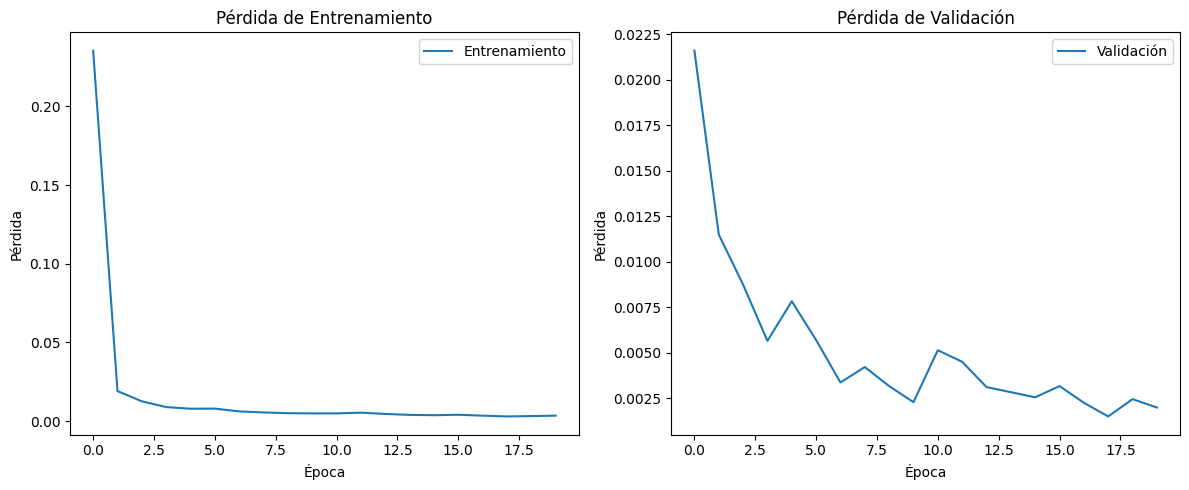


Informe de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     47047
         1.0       1.00      0.99      1.00      5318

    accuracy                           1.00     52365
   macro avg       1.00      1.00      1.00     52365
weighted avg       1.00      1.00      1.00     52365



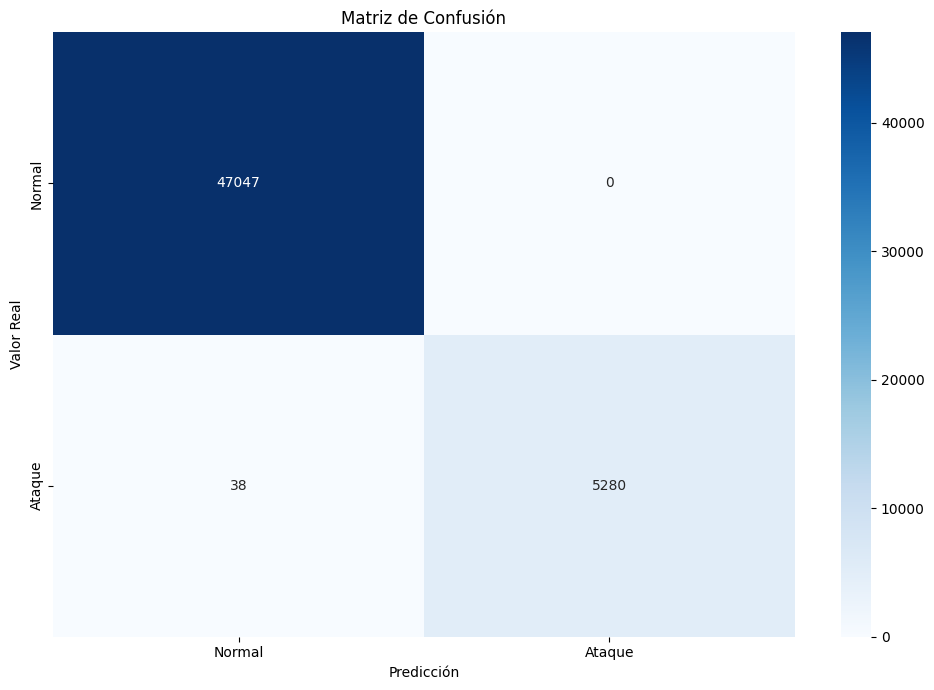

Precisión: 1.0000
Sensibilidad: 0.9929
F1 Score: 0.9964

Resumen del entrenamiento:
Pérdida final de entrenamiento: 0.0035
Pérdida final de validación: 0.0020


In [32]:
def train_rnn(attacked_data, sequence_length=10, hidden_size=64, num_layers=2, 
              dropout=0.2, lr=0.001, num_epochs=100, batch_size=32, patience=7):
    
    # Preparar secuencias
    X_seq, y_seq = prepare_sequences(attacked_data, sequence_length)
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    
    # Convertir a tensores
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train = torch.FloatTensor(X_train).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    y_train = torch.FloatTensor(y_train).view(-1, 1).to(device)
    y_test = torch.FloatTensor(y_test).view(-1, 1).to(device)
    
    # Crear datasets y dataloaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Inicializar modelo
    input_size = X_train.shape[2]
    model = RNN1D(input_size, hidden_size, num_layers, dropout).to(device)
    
    # Criterio y optimizador
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Early stopping
    best_loss = float('inf')
    counter = 0
    best_model_state = None
    
    # Listas para almacenar pérdidas
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validación
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            val_loss = criterion(test_outputs, y_test)
            val_losses.append(val_loss.item())
            predicted = (test_outputs >= 0.5).float()
            accuracy = (predicted == y_test).float().mean().item()
            
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
        
        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping en la época {epoch+1}")
                break
    
    # Cargar mejor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Evaluación final
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        predicted = (test_outputs >= 0.5).float()
        y_pred = predicted.cpu().numpy().flatten()
        y_true = y_test.cpu().numpy().flatten()
    
    # Visualizar curvas de aprendizaje
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Entrenamiento')
    plt.title('Pérdida de Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_losses, label='Validación')
    plt.title('Pérdida de Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\nInforme de clasificación:")
    print(classification_report(y_true, y_pred))
    mostrar_matriz_confusion(y_true, y_pred)
    
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'y_pred': y_pred,
        'y_true': y_true
    }

# Preparar datos para ataque DoS determinista
step = len(data) // 26000  # 10 por ciento de los datos atacados

attacked_data = data.copy()
scaler = StandardScaler()
attacked_data.iloc[:, :] = scaler.fit_transform(attacked_data)
attacked_data['attack_label'] = 0

# Aplicar ataques DoS
for i in range(0, len(data), step):
    attacked_data.iloc[i, attacked_data.columns.get_loc('COMBU.CALD5.O2')] = 0
    attacked_data.iloc[i, attacked_data.columns.get_loc('attack_label')] = 1

# Entrenar RNN
model, history = train_rnn(attacked_data, 
                          sequence_length=10,
                          hidden_size=64,
                          num_layers=2,
                          dropout=0.2,
                          lr=0.001,
                          num_epochs=20,
                          batch_size=32,
                          patience=7)

# Mostrar resultados adicionales (opcional)
print("\nResumen del entrenamiento:")
print(f"Pérdida final de entrenamiento: {history['train_losses'][-1]:.4f}")
print(f"Pérdida final de validación: {history['val_losses'][-1]:.4f}")


Combinación 1/8: {'num_epochs': 20, 'hidden_size': 32, 'num_layers': 1, 'learning_rate': 0.001}
  Training fold 1/5...
  Fold 1 - Accuracy: 0.9981, Epochs: 20
  Training fold 2/5...
  Fold 2 - Accuracy: 0.9972, Epochs: 20
  Training fold 3/5...
  Fold 3 - Accuracy: 0.9980, Epochs: 20
  Training fold 4/5...
  Fold 4 - Accuracy: 0.9985, Epochs: 20
  Training fold 5/5...
  Fold 5 - Accuracy: 0.9990, Epochs: 20
  Promedio: Accuracy 0.9982 ± 0.0006, Épocas 20.0

Combinación 2/8: {'num_epochs': 20, 'hidden_size': 32, 'num_layers': 1, 'learning_rate': 0.002}
  Training fold 1/5...
  Fold 1 - Accuracy: 0.9994, Epochs: 20
  Training fold 2/5...
  Fold 2 - Accuracy: 0.9975, Epochs: 20
  Training fold 3/5...
  Fold 3 - Accuracy: 0.9978, Epochs: 20
  Training fold 4/5...
  Fold 4 - Accuracy: 0.9991, Epochs: 20
  Training fold 5/5...
  Fold 5 - Accuracy: 0.9993, Epochs: 20
  Promedio: Accuracy 0.9986 ± 0.0008, Épocas 20.0

Combinación 3/8: {'num_epochs': 20, 'hidden_size': 32, 'num_layers': 2, 'le

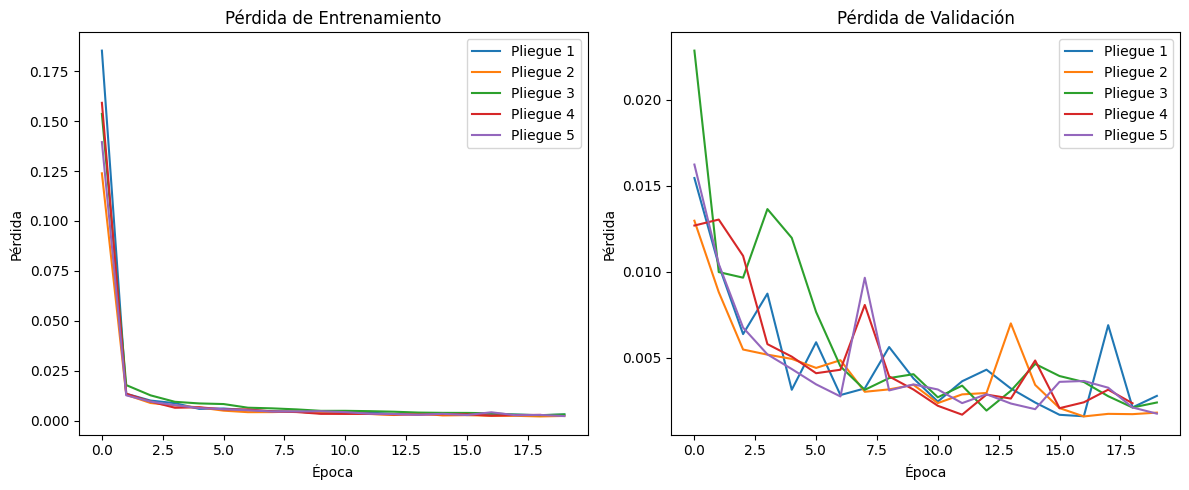


Matriz de confusión (acumulada en los pliegues):
[[235623     17]
 [   176  26007]]


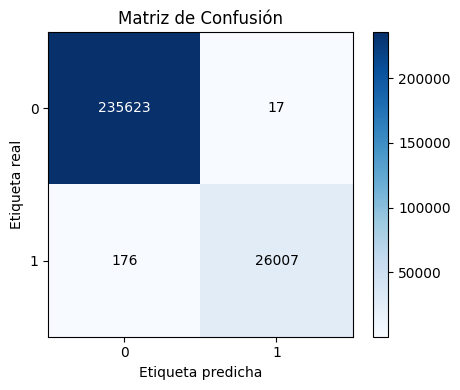

In [33]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from itertools import product

# Grid de hiperparámetros para la RNN
param_grid = {
    'num_epochs': [20],
    'hidden_size': [32, 64],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.002]
}

# Preparar datos
X_seq, y_seq = prepare_sequences(attacked_data, sequence_length=10)

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_result = None
best_accuracy = 0
best_params = None

param_combinations = list(dict(zip(param_grid.keys(), values)) for values in product(*param_grid.values()))

def train_evaluate_rnn(params, train_idx, test_idx, X_seq, y_seq):
    # Preparar datos
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]
    
    # Crear DataLoader para procesar en batches
    batch_size = 64  # Reducido de tamaño
    train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train).view(-1, 1)
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    
    # Inicializar modelo
    input_size = X_train.shape[2]
    model = RNN1D(input_size, params['hidden_size'], params['num_layers']).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 7
    counter = 0
    
    for epoch in range(params['num_epochs']):
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        # Entrenar por batches
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
            
        avg_train_loss = epoch_loss / batch_count
        train_losses.append(avg_train_loss)
        
        # Validación también por batches
        model.eval()
        val_loss = 0
        val_batches = 0
        all_preds = []
        all_labels = []
        
        # Procesar test set en batches
        test_dataset = torch.utils.data.TensorDataset(
            torch.FloatTensor(X_test),
            torch.FloatTensor(y_test).view(-1, 1)
        )
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=batch_size
        )
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                test_outputs = model(batch_X)
                val_loss += criterion(test_outputs, batch_y).item()
                predicted = (test_outputs >= 0.5).float()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break
    
    # Calcular accuracy final
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    accuracy = np.mean(all_preds == all_labels)
    
    return {
        'accuracy': accuracy,
        'y_pred': all_preds,
        'y_true': all_labels,
        'epochs_used': len(train_losses),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
# Entrenamiento con validación cruzada
for i, params in enumerate(param_combinations):
    fold_results = []
    
    print(f"\nCombinación {i+1}/{len(param_combinations)}: {params}")
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_seq, y_seq)):
        print(f"  Training fold {fold+1}/{n_folds}...")
        
        result = train_evaluate_rnn(params, train_idx, test_idx, X_seq, y_seq)
        fold_results.append(result)
        
        print(f"  Fold {fold+1} - Accuracy: {result['accuracy']:.4f}, Epochs: {result['epochs_used']}")
    
    avg_accuracy = np.mean([r['accuracy'] for r in fold_results])
    std_accuracy = np.std([r['accuracy'] for r in fold_results])
    avg_epochs = np.mean([r['epochs_used'] for r in fold_results])
    
    print(f"  Promedio: Accuracy {avg_accuracy:.4f} ± {std_accuracy:.4f}, Épocas {avg_epochs:.1f}")
    
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_params = params
        best_result = {
            'params': params,
            'avg_accuracy': avg_accuracy,
            'std_accuracy': std_accuracy,
            'avg_epochs': avg_epochs,
            'fold_results': fold_results
        }

print(f"\nMejor combinación: {best_params}")
print(f"Mejor accuracy promedio: {best_accuracy:.4f}")

mostrar_resultados_grid_search([best_result])